In [1]:
#Setting up the environment

import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import random_uniform, glorot_uniform
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
import os
import shutil
import json

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k

2024-08-16 22:50:48.187495: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 22:50:48.187608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 22:50:48.323988: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## Helper Functions


def aggregate_training_history(histories):
    """
    Aggregates training history from multiple model training runs.
    
    Args:
    histories (list): List of Keras History objects to be merged.
    
    Returns:
    dict: Merged history containing aggregated loss and accuracy metrics for training and validation.
    """
    combined_history = {}
    for key in histories[0].history.keys():
        combined_history[key] = sum([h.history[key] for h in histories], [])
    return combined_history

def plot_training_progress(history, metrics=None, start_epoch=1):
    """
    Visualizes the training and validation metrics over epochs.
    
    Args:
    history (dict): Dictionary containing training and validation metrics.
    metrics (list): List of metrics to plot. If None, all metrics will be plotted.
    start_epoch (int): Starting epoch to plot the metrics.
    
    Returns:
    None: The function plots the graphs.
    """
    # Define the range of epochs to plot
    epoch_range = range(start_epoch, len(history['loss']) + 1)
    s = slice(start_epoch - 1, None)

    # Set up the figure
    plt.figure(figsize=[16, 6])
    
    if metrics is None:
        # If no specific metrics are passed, use all available metrics
        metrics = [k for k in history.keys() if not k.startswith('val_')]

    # Plot each metric and its validation counterpart
    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i + 1)
        plt.plot(epoch_range, history[metric][s], label='Training')
        plt.plot(epoch_range, history['val_' + metric][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(metric); plt.title(f'{metric.capitalize()} Progress')
        plt.grid(True)
        plt.legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


def setup_environment():
    """
    This function sets up the environment dynamically by ensuring that
    all necessary libraries are installed. It also verifies the TensorFlow version.
    """
    required_libraries = ['tensorflow', 'numpy', 'matplotlib', 'seaborn', 'pandas']
    for lib in required_libraries:
        try:
            __import__(lib)
        except ImportError:
            print(f"Installing missing library: {lib}")
            os.system(f"pip install {lib}")
    
    print("Environment setup is complete.")


# Call the environment setup function to ensure the environment is ready.
setup_environment()

In [3]:
## Importing training data for testing - Set to string since Categorical Classes are being used. 
## Avoiding Binary in case of additional classes being added in the future.
train = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv', dtype=str)
print(train.shape)

(220025, 2)


In [4]:
## Concatenating train.id with .tif to ensure model can properly read the images.
train.id = train.id + '.tif'
train.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7.tif,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da.tif,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f.tif,1
8,559e55a64c9ba828f700e948f6886f4cea919261.tif,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4.tif,0


In [5]:
## Label Distribution

(train.label.value_counts() / len(train)).to_frame().sort_index().T

label,0,1
count,0.594969,0.405031


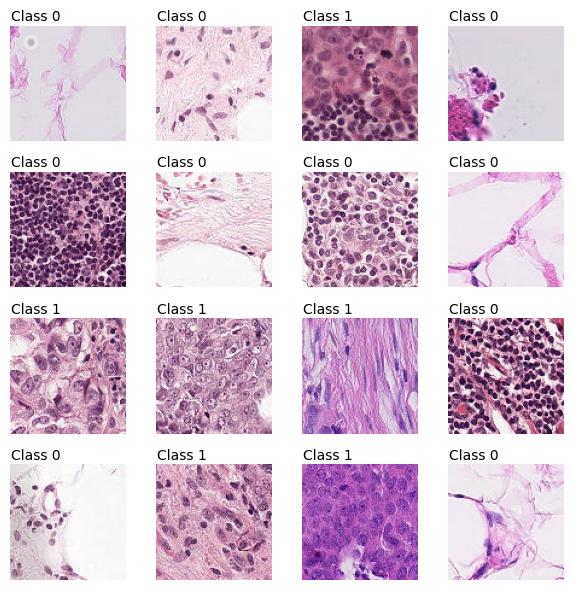

In [6]:
## Image Extraction

train_path = "../input/histopathologic-cancer-detection/train"

sample = train.sample(n=16).reset_index()

plt.figure(figsize=(6,6))

for i, row in sample.iterrows():
    
    img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{row.id}')
    label = row.label
    
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0,-5, f'Class {label}', color='k')
    plt.axis('off')
    
plt.tight_layout()
plt.show()
    

In [7]:
## Training and Validation Set Creation
train_df, valid_df = train_test_split(train, test_size = 0.2, random_state = 1, stratify = train.label)

## Data Generators
## Image Augmentation set only for training to maintain controls.

train_datagen = ImageDataGenerator(
    rescale = 1/255,
##    shear_range = 0.1,
##    zoom_range = 0.1
                                  )
validation_datagen = ImageDataGenerator(
    rescale = 1/255)

In [8]:
## Setting Batch Sizes - Attempting manual batch_size to fix an error
## BATCH_SIZE = 32 (changed from 64) 

## Setting Batch Size with variable, seed, and target size.
train_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = 32,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (64,64)
)


valid_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = 32,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (64,64)
)

Found 44005 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [9]:
## Verify number of steps is correct according to previous parameters
TR_STEPS = len(train_loader)
VA_STEPS = len(valid_loader)

print(TR_STEPS) 
print(VA_STEPS)

1376
1376


In [10]:
## Pre-Trained Model to set Convolutional Base
## Setting image size to 32x32 to reduce initial load time.
## Creating Base Model

base_model = tf.keras.applications.VGG19(
    input_shape = (64,64,3),
    include_top = False,
    weights = 'imagenet'
)

base_model.trainable = False

## Verify Base Model looks correct and layers show appropriately
base_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [11]:
## Building Convolutional Neural Network
np.random.seed(1)
tf.random.set_seed(1)

cnn = Sequential([
    base_model,
    BatchNormalization(),
    
    Flatten(),
    
    Dense(64, activation = 'relu'),
    Dropout(0.5),
    Dense(32, activation = 'relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation = 'softmax')
])


In [12]:
## Causing following error: ValueError: Undefined shapes are not supported.
## cnn.summary()

In [13]:
## Fine tuning - setting epochs lower to allow for quicker testing at first.
## WEEK 6 - Added additional 0 to optimizer to see if results improve with large images.

opt = tf.keras.optimizers.Adam(0.0001)
cnn.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [14]:
## First iteration to test 16 Epochs using parameters set.
## Ommitting steps_per_epoch and validation_steps correcting error in epoch processing. <--- Error Fix.

h1 = cnn.fit(
    x = train_loader,
##    steps_per_epoch = TR_STEPS,
    validation_data = valid_loader,
##    validation_steps = VA_STEPS,
    epochs = 20,
    verbose = 1
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   1/1376 ━━━━━━━━━━━━━━━━━━━━ 4:06:02 11s/step - accuracy: 0.5625 - auc: 0.5859 - loss: 0.7843

I0000 00:00:1723848778.253365      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723848778.283754      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1374/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6437 - auc: 0.6962 - loss: 0.7147

W0000 00:00:1723849000.906655      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 292s 204ms/step - accuracy: 0.6438 - auc: 0.6963 - loss: 0.7146 - val_accuracy: 0.5950 - val_auc: 0.6483 - val_loss: 0.6823
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 125s 91ms/step - accuracy: 0.7378 - auc: 0.8099 - loss: 0.5508 - val_accuracy: 0.5950 - val_auc: 0.6302 - val_loss: 0.6933
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 121s 88ms/step - accuracy: 0.7576 - auc: 0.8329 - loss: 0.5131 - val_accuracy: 0.5950 - val_auc: 0.6667 - val_loss: 0.6774
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 122s 88ms/step - accuracy: 0.7753 - auc: 0.8500 - loss: 0.4877 - val_accuracy: 0.7230 - val_auc: 0.8133 - val_loss: 1.5372
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 121s 87ms/step - accuracy: 0.7777 - auc: 0.8567 - loss: 0.4753 - val_accuracy: 0.5950 - val_auc: 0.7651 - val_loss: 0.9062
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 120s 87ms/step - accuracy: 0.7877 - auc: 0.8651 - loss: 0.4631 - val_accuracy: 0.5950 - val_auc: 0.7007 - val_loss: 0.6928
Epoch 7/20
1376/1376

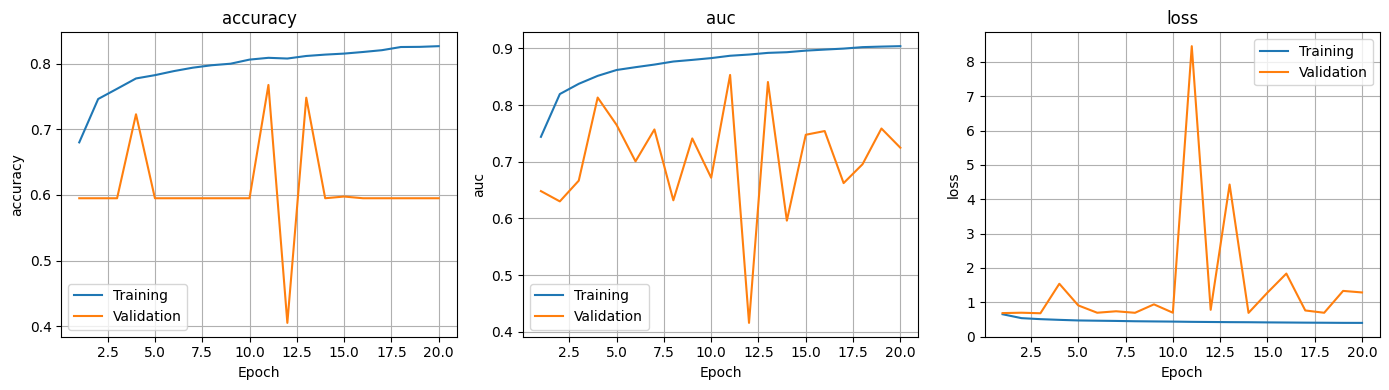

In [15]:
## Merge history to store results
history = merge_history([h1])
vis_training(history)

In [16]:
## Fine tuning for 2nd iteration - Check learning rate schedules for potential model improvements.
base_model.trainable = False
learning_rate = tf.Variable(0.0001, trainable = False)

learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps = 10000,
    decay_rate = 0.94
)

opt2 = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
## k.set_value(cnn.optimizer.learning_rate, 0.0001)

cnn.compile(
    loss = 'categorical_crossentropy',
    optimizer = opt2,
    metrics = ['accuracy', tf.keras.metrics.AUC()]
)



In [17]:
## Fine tuned using altered optimizer and learning rate scheduler to compare results of previous iteration to new h2 model.

h2 = cnn.fit(
    x = train_loader,
    validation_data = valid_loader,
    epochs = 20,
    verbose = 1
)

Epoch 1/20
   5/1376 ━━━━━━━━━━━━━━━━━━━━ 50s 37ms/step - accuracy: 0.8364 - auc_1: 0.9334 - loss: 0.3397

W0000 00:00:1723851389.109838      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1374/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7964 - auc_1: 0.8756 - loss: 0.4450

W0000 00:00:1723851454.857226      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 133s 91ms/step - accuracy: 0.7964 - auc_1: 0.8756 - loss: 0.4450 - val_accuracy: 0.5950 - val_auc_1: 0.6606 - val_loss: 0.6914
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 120s 87ms/step - accuracy: 0.8042 - auc_1: 0.8816 - loss: 0.4352 - val_accuracy: 0.5950 - val_auc_1: 0.6941 - val_loss: 0.6872
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 122s 88ms/step - accuracy: 0.8102 - auc_1: 0.8892 - loss: 0.4240 - val_accuracy: 0.6128 - val_auc_1: 0.7789 - val_loss: 7.9051
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 119s 86ms/step - accuracy: 0.8137 - auc_1: 0.8922 - loss: 0.4177 - val_accuracy: 0.6979 - val_auc_1: 0.8128 - val_loss: 7.5220
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 118s 85ms/step - accuracy: 0.8188 - auc_1: 0.8965 - loss: 0.4094 - val_accuracy: 0.5950 - val_auc_1: 0.5949 - val_loss: 0.7488
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 119s 87ms/step - accuracy: 0.8238 - auc_1: 0.9003 - loss: 0.4038 - val_accuracy: 0.5950 - val_auc_1: 0.7267 - val_loss: 0.79

In [18]:
## Merge h2 history with h1 history can display results.

h2.history['auc'] = h2.history['auc_1']
h2.history['val_auc'] = h2.history['val_auc_1']

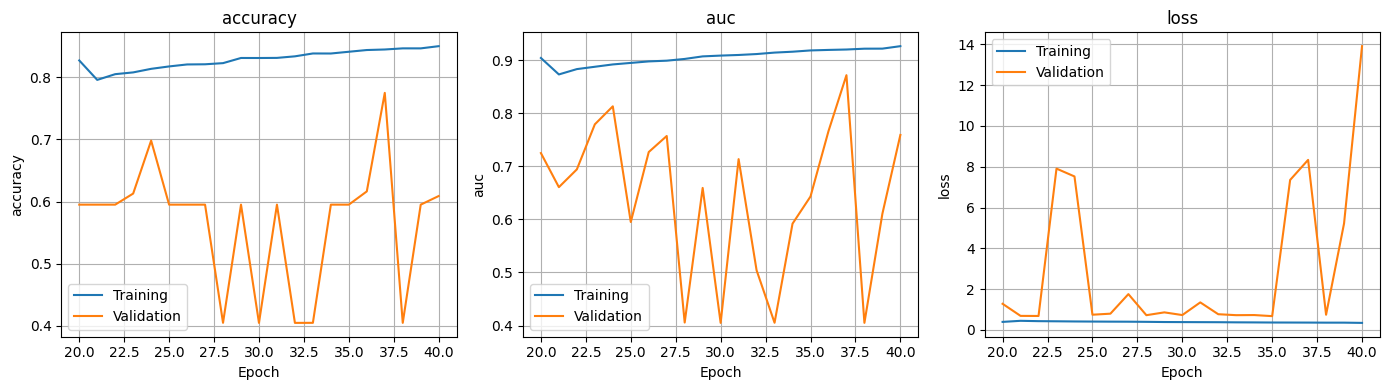

In [19]:
history = merge_history([h1, h2])
vis_training(history, start = 20)

In [20]:
## Third Iteration

h3 = cnn.fit(
    x = train_loader,
    validation_data = valid_loader,
    epochs = 20,
    verbose = 1
)

Epoch 1/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 127s 92ms/step - accuracy: 0.8519 - auc_1: 0.9265 - loss: 0.3484 - val_accuracy: 0.4050 - val_auc_1: 0.4309 - val_loss: 0.8862
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 126s 92ms/step - accuracy: 0.8448 - auc_1: 0.9249 - loss: 0.3514 - val_accuracy: 0.5950 - val_auc_1: 0.5951 - val_loss: 0.6794
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 130s 94ms/step - accuracy: 0.8558 - auc_1: 0.9292 - loss: 0.3425 - val_accuracy: 0.5950 - val_auc_1: 0.6819 - val_loss: 1.0264
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 135s 98ms/step - accuracy: 0.8520 - auc_1: 0.9265 - loss: 0.3486 - val_accuracy: 0.5950 - val_auc_1: 0.5991 - val_loss: 0.8491
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 128s 93ms/step - accuracy: 0.8528 - auc_1: 0.9287 - loss: 0.3438 - val_accuracy: 0.5950 - val_auc_1: 0.6417 - val_loss: 3.6381
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 130s 94ms/step - accuracy: 0.8558 - auc_1: 0.9311 - loss: 0.3377 - val_accuracy: 0.5950 - val_auc_1: 0.6031 - val

In [21]:
## Merge h3 history with h2 and h1 history can display results.

h3.history['auc'] = h3.history['auc_1']
h3.history['val_auc'] = h3.history['val_auc_1']

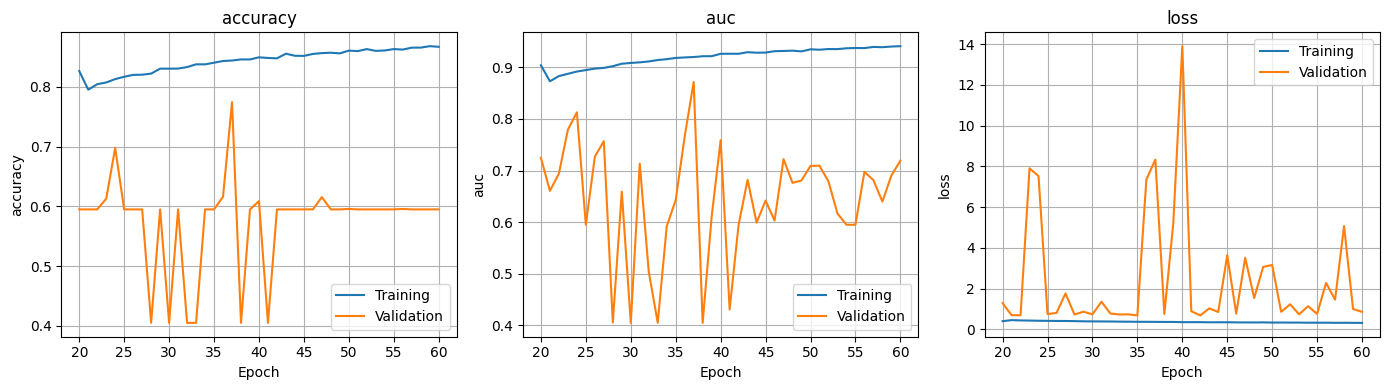

In [22]:
history = merge_history([h1, h2, h3])
vis_training(history, start = 20)

In [23]:
h4 = cnn.fit(
    x = train_loader,
    validation_data = valid_loader,
    epochs = 20,
    verbose = 1
)

Epoch 1/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 124s 90ms/step - accuracy: 0.8664 - auc_1: 0.9407 - loss: 0.3128 - val_accuracy: 0.5950 - val_auc_1: 0.6580 - val_loss: 1.0607
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 125s 90ms/step - accuracy: 0.8673 - auc_1: 0.9399 - loss: 0.3165 - val_accuracy: 0.7051 - val_auc_1: 0.8111 - val_loss: 17.1861
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 122s 88ms/step - accuracy: 0.8682 - auc_1: 0.9420 - loss: 0.3099 - val_accuracy: 0.5950 - val_auc_1: 0.6894 - val_loss: 1.1176
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 125s 90ms/step - accuracy: 0.8685 - auc_1: 0.9405 - loss: 0.3138 - val_accuracy: 0.5950 - val_auc_1: 0.7268 - val_loss: 0.7866
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 126s 91ms/step - accuracy: 0.8673 - auc_1: 0.9425 - loss: 0.3084 - val_accuracy: 0.5950 - val_auc_1: 0.6358 - val_loss: 1.3272
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 122s 89ms/step - accuracy: 0.8657 - auc_1: 0.9414 - loss: 0.3112 - val_accuracy: 0.5950 - val_auc_1: 0.6444 - va

In [24]:
## Assign and merge 4th iteration to verify results after error.

h4.history['auc'] = h4.history['auc_1']
h4.history['val_auc'] = h4.history['val_auc_1']

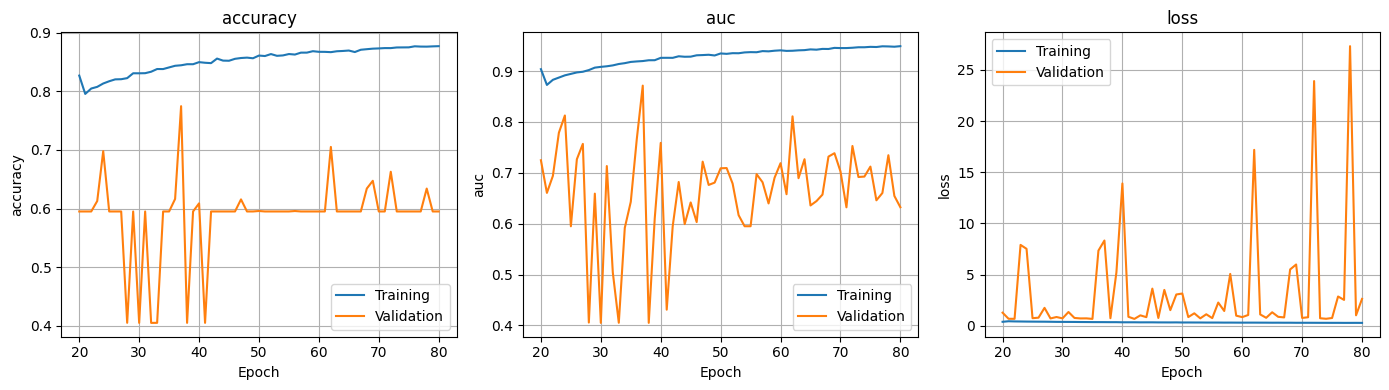

In [25]:
history = merge_history([h1, h2, h3, h4])
vis_training(history, start = 20)

In [26]:
## Saving output

cnn.save('HCD.h5')
pickle.dump(history, open(f'HCD.pk1', 'wb'))

In [27]:
## Setting up for submission
test = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
test_path = "../input/histopathologic-cancer-detection/test"
test['filename'] = test.id + '.tif'

In [28]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_loader = train_datagen.flow_from_dataframe(
    dataframe = test,
    directory = test_path,
    x_col = 'filename',
    batch_size = 32,
    shuffle = False,
    class_mode = None,
    target_size = (64,64)
)

Found 57458 validated image filenames.


In [29]:
test_probs = cnn.predict(test_loader)
test_pred = np.argmax(test_probs, axis = 1)


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   3/1796 ━━━━━━━━━━━━━━━━━━━━ 2:33 86ms/step  

W0000 00:00:1723859133.559372      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 295s 164ms/step


W0000 00:00:1723859427.621722      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [30]:
submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [31]:
submission.label = test_probs[:,1]
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.283402
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.256559
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.203591
3,2c35657e312966e9294eac6841726ff3a748febf,0.219280
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.222335


In [32]:
submission.to_csv('submission.csv', header = True, index = False)